Training SVM...


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


Best parameters for SVM: {'C': 10, 'kernel': 'rbf'}

SVM Results:
Accuracy: 0.956989247311828
Precision: 0.9567567567567568
Training Naive Bayes...

Naive Bayes Results:
Accuracy: 0.9516129032258065
Precision: 0.9516129032258065
Epoch 1/20
47/47 [==============================] - 4s 61ms/step - loss: 0.4709 - accuracy: 0.8605 - val_loss: 0.1922 - val_accuracy: 0.9516
Epoch 2/20
47/47 [==============================] - 1s 31ms/step - loss: 0.2178 - accuracy: 0.9488 - val_loss: 0.1903 - val_accuracy: 0.9516
Epoch 3/20
47/47 [==============================] - 2s 33ms/step - loss: 0.2010 - accuracy: 0.9488 - val_loss: 0.1864 - val_accuracy: 0.9516
Epoch 4/20
47/47 [==============================] - 1s 31ms/step - loss: 0.1878 - accuracy: 0.9488 - val_loss: 0.1792 - val_accuracy: 0.9516
Epoch 5/20
47/47 [==============================] - 1s 30ms/step - loss: 0.1532 - accuracy: 0.9488 - val_loss: 0.1733 - val_accuracy: 0.9516
Epoch 6/20
47/47 [==============================] - 1s 31ms/step -

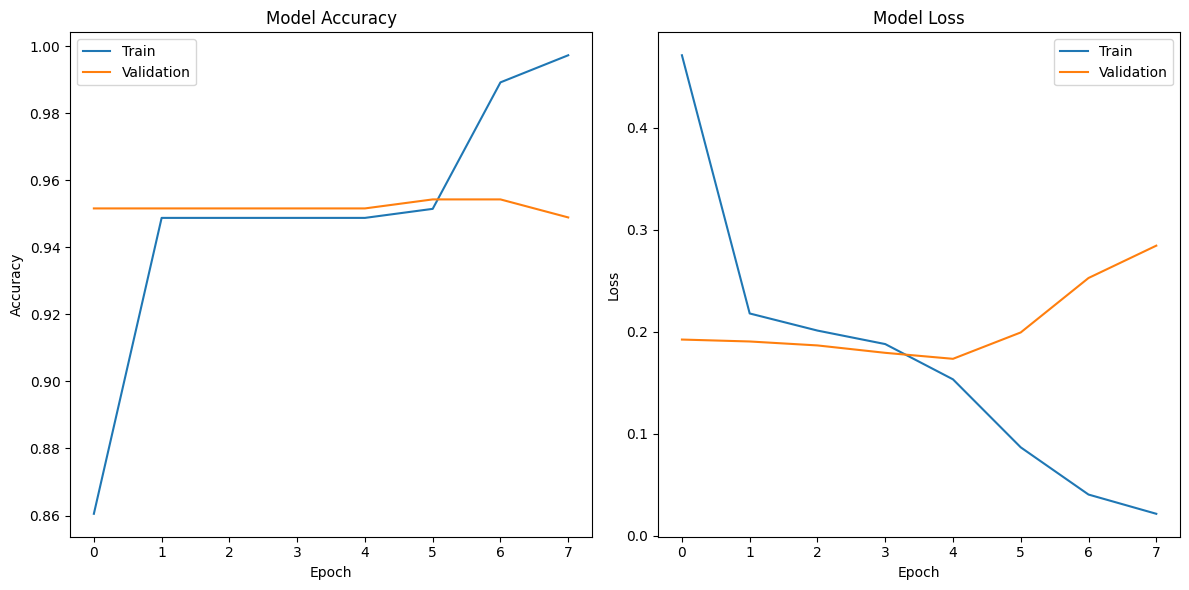

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, Dense, Dropout, Conv1D, GlobalMaxPooling1D
from keras.callbacks import EarlyStopping
from keras.models import load_model
from joblib import dump
from bs4 import BeautifulSoup
import requests

# Load the CSV file
df = pd.read_csv('final_merged.csv')
df = df.dropna(subset=['title'])
df['negative_score'] = pd.to_numeric(df['negative_score'], errors='coerce')

# Drop rows with NaN values in 'negative_score' after conversion
df = df.dropna(subset=['negative_score'])

# Define the target variable
threshold = -0.8
df['target'] = (df['negative_score'] < threshold).astype(int)

# Ensure both classes are present in the dataset
if df['target'].nunique() < 2:
    raise ValueError("Target variable contains only one class. Please adjust the threshold or gather more data.")

# Split the data into features and target
X = df['title']
y = df['target']

# Preprocess the text data for TF-IDF
vectorizer = TfidfVectorizer(max_features=5000)
X_tfidf = vectorizer.fit_transform(X)

# Split the data into training and testing sets
X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

# Define and tune models using TF-IDF
models = {
    'SVM': SVC(),
    'Naive Bayes': MultinomialNB()
}

param_grids = {
    'SVM': {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']},
}

def evaluate_and_save_models():
    for model_name, model in models.items():
        print(f"Training {model_name}...")
        if model_name in param_grids:
            grid_search = GridSearchCV(model, param_grids[model_name], cv=5, n_jobs=-1)
            grid_search.fit(X_train_tfidf, y_train)
            best_model = grid_search.best_estimator_
            print(f"Best parameters for {model_name}: {grid_search.best_params_}")
        else:
            best_model = model
            best_model.fit(X_train_tfidf, y_train)

        y_pred = best_model.predict(X_test_tfidf)

        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)

        print(f"\n{model_name} Results:")
        print(f"Accuracy: {accuracy}")
        print(f"Precision: {precision}")

        # Save the model
        if model_name == 'SVM':
            dump(best_model, 'svm_model.pkl')
        elif model_name == 'Naive Bayes':
            dump(best_model, 'naive_bayes_model.pkl')

evaluate_and_save_models()

# Preprocess the text data for CNN
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(df['title'])
sequences = tokenizer.texts_to_sequences(df['title'])
padded_sequences = pad_sequences(sequences, maxlen=200)

# Split the data into training and testing sets for CNN
X_train_cnn, X_test_cnn, y_train, y_test = train_test_split(padded_sequences, y, test_size=0.2, random_state=42)

# Define and compile the CNN model
cnn_model = Sequential()
cnn_model.add(Embedding(input_dim=5000, output_dim=100, input_length=200))
cnn_model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))  # Reduced filters and kernel size
cnn_model.add(GlobalMaxPooling1D())
cnn_model.add(Dropout(0.3))  # Increased dropout rate
cnn_model.add(Dense(32, activation='relu'))  # Reduced units in Dense layer
cnn_model.add(Dropout(0.3))  # Increased dropout rate
cnn_model.add(Dense(1, activation='sigmoid'))
cnn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Implement early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the CNN model and capture the history
history = cnn_model.fit(X_train_cnn, y_train, epochs=20, batch_size=32, validation_data=(X_test_cnn, y_test), callbacks=[early_stopping])

# Evaluate the CNN model
y_pred_cnn = cnn_model.predict(X_test_cnn)
y_pred_cnn = (y_pred_cnn > 0.5).astype(int).flatten()

accuracy_cnn = accuracy_score(y_test, y_pred_cnn)
precision_cnn = precision_score(y_test, y_pred_cnn)

print("\nCNN Results:")
print(f"Accuracy: {accuracy_cnn}")
print(f"Precision: {precision_cnn}")

# Save the CNN model
cnn_model.save('cnn_model.keras')

# Save the tokenizer and vectorizer
dump(tokenizer, 'tokenizer.pkl')
dump(vectorizer, 'vectorizer.pkl')

# Save the final dataframe to CSV
df.to_csv('negative_articles_final.csv', index=False)

# Plot loss and accuracy curves
plt.figure(figsize=(12, 6))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])

plt.tight_layout()
plt.show()


In [ ]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import joblib
from keras.models import load_model
from keras.preprocessing.sequence import pad_sequences
from concurrent.futures import ThreadPoolExecutor, as_completed
import threading
from queue import Queue
import time
import re

# Load the models and tokenizer
svm_model = joblib.load('svm_model.pkl')
naive_bayes_model = joblib.load('naive_bayes_model.pkl')
cnn_model = load_model('cnn_model.keras', compile=False)  # Added compile=False for safety
tokenizer = joblib.load('tokenizer.pkl')
vectorizer = joblib.load('vectorizer.pkl')

# Define critical keywords
critical_keywords = [
    "scam", "fraud", "criticism", "arrest", "rape", "murder", "controversy",
    "cheating", "deception", "embezzlement", "corruption", "theft", "robbery",
    "abuse", "scandal", "lawsuit", "indictment", "conviction", "protest",
    "riot", "assault", "harassment", "bribery", "extortion", "violence",
    "homicide", "manslaughter", "kidnapping", "false claims", "misconduct",
    "defamation", "libel", "slander", "betrayal", "backlash", "boycott",
    "outcry", "dispute", "disgrace", "shame", "infamy", "guilty", "sentence",
    "trial", "violation", "injustice", "subversion", "treason", "perjury",
    "fraudulent", "fraudster", "misrepresentation", "falsification", "forgery",
    "malpractice", "negligence", "persecution", "oppression", "misappropriation",
    "money laundering", "racketeering", "organized crime", "drug trafficking",
    "human trafficking", "cybercrime", "hacking", "phishing", "scamming",
    "counterfeit", "piracy", "exploitation"
]

def search_articles(personality, pages=5):
    query = f'"{personality}" AND (' + ' OR '.join(f'"{keyword}"' for keyword in critical_keywords) + ')'
    all_links = set()

    for page in range(pages):
        start = page * 10
        url = f"https://www.google.com/search?q={query}&tbm=nws&start={start}"
        headers = {"User-Agent": "Mozilla/5.0"}
        response = requests.get(url, headers=headers)
        soup = BeautifulSoup(response.text, 'html.parser')

        for item in soup.find_all('a', href=True):
            href = item['href']
            if "/url?q=" in href:
                link = href.split("/url?q=")[1].split('&')[0]
                if link.startswith('http') and 'google' not in link and 'maps' not in link:
                    all_links.add(link)
        time.sleep(2)  # Delay to avoid hitting rate limits

    return list(all_links)

def fetch_and_process_articles(links, personality):
    article_queue = Queue()
    for link in links:
        article_queue.put(link)

    def process_article():
        while not article_queue.empty():
            link = article_queue.get()
            article_text = get_article_content(link)
            if article_text:
                title = get_title_from_article(link)
                if is_relevant_article(personality, title, article_text):
                    sentiment = predict_sentiment(title, article_text)
                    if sentiment == 1:  # negative sentiment
                        critical_articles.append((link, title))
            article_queue.task_done()

    critical_articles = []
    num_threads = min(10, len(links))
    threads = []
    for _ in range(num_threads):
        thread = threading.Thread(target=process_article)
        thread.start()
        threads.append(thread)

    for thread in threads:
        thread.join()

    return critical_articles

def get_article_content(url):
    try:
        response = requests.get(url, headers={"User-Agent": "Mozilla/5.0"})
        if response.status_code == 200:
            soup = BeautifulSoup(response.text, 'html.parser')
            paragraphs = soup.find_all('p')
            content = ''.join([p.get_text() for p in paragraphs])
            return content
        else:
            print(f"Error fetching article content from {url}: Status code {response.status_code}")
            return ""
    except Exception as e:
        print(f"Error fetching article content from {url}: {e}")
        return ""

def get_title_from_article(url):
    try:
        response = requests.get(url, headers={"User-Agent": "Mozilla/5.0"})
        if response.status_code == 200:
            soup = BeautifulSoup(response.text, 'html.parser')
            if soup.title:
                return soup.title.string.strip()
            else:
                return ""
        else:
            print(f"Error fetching title from {url}: Status code {response.status_code}")
            return ""
    except Exception as e:
        print(f"Error fetching title from {url}: {e}")
        return ""

def is_relevant_article(personality, title, content):
    # Check if the title contains any critical keywords
    if any(re.search(keyword, title, re.IGNORECASE) for keyword in critical_keywords):
        # Check if the article mentions the personality or related keywords
        if re.search(personality, title, re.IGNORECASE) or re.search(personality, content, re.IGNORECASE):
            return True
    return False

def predict_sentiment(title, content):
    combined_text = title + " " + content
    combined_tfidf_vector = vectorizer.transform([combined_text])
    combined_cnn_sequences = tokenizer.texts_to_sequences([combined_text])
    combined_cnn_padded = pad_sequences(combined_cnn_sequences, maxlen=200)

    svm_pred = svm_model.predict(combined_tfidf_vector)[0]
    nb_pred = naive_bayes_model.predict(combined_tfidf_vector)[0]
    cnn_pred = cnn_model.predict(combined_cnn_padded)[0][0]

    pred = int(np.round((svm_pred + nb_pred + cnn_pred) / 3))
    return pred

if __name__ == "__main__":
    personality = input("Enter the name of the personality or a Company: ")
    links = search_articles(personality, pages=5)
    critical_articles = fetch_and_process_articles(links, personality)
    print(f"Found {len(critical_articles)} critical articles about {personality}:")

    for article in critical_articles:
        print(f"Link: {article[0]}, Title: {article[1]}")


Enter the name of the personality or a Company: Nawaz Sharif
Error fetching article content from https://www.reuters.com/article/world/timeline-the-three-time-rise-and-fall-of-pakistans-nawaz-sharif-idUSKBN1JW1O3/: Status code 401
Error fetching article content from https://www.reuters.com/world/asia-pacific/pakistan-court-forbids-arrest-ex-pm-nawaz-sharif-his-return-2023-10-19/: Status code 401
1/1 [==============================] - 0s 100ms/step
Error fetching article content from https://www.reuters.com/world/asia-pacific/nawaz-sharifs-daughter-elected-head-pakistans-punjab-seen-stepping-stone-2024-02-26/: Status code 401
Error fetching article content from https://www.reuters.com/world/asia-pacific/pakistan-court-overturns-ex-pm-nawaz-sharifs-last-graft-conviction-2023-12-12/: Status code 401
1/1 [==============================] - 0s 126ms/step
Error fetching article content from https://www.reuters.com/world/asia-pacific/pakistan-court-overturns-ex-pm-nawaz-sharifs-graft-convictio